# Difficulty-Adaptive Reasoning Simulator

**Author:** Rhishi Kumar Ayyappan

---

## Project Overview

This Colab-ready project simulates the key lessons from DiffAdapt:  
- Models should spend less effort (tokens) on easy problems, and more on hard ones, for efficient and reliable reasoning.
- Collapse/failure points are flagged and annotated, with visual comparison of baseline versus adaptive strategies.
- All logic, visualization, and benchmarking can be run on Google Colab using free/public model endpoints.

---

## Key Features

- **Auto-detected Difficulty:** Uses problem length as a simple proxy for "difficulty class" (easy, medium, hard).
- **Adaptive Reasoning Modes:** Chooses short answers for easy, standard chain-of-thought for medium, and longer or sampled chains for hard problems.
- **Visual Metrics:** Plots total tokens used, accuracy, and collapse locations for both fixed and adaptive strategies.
- **Failure Flags:** Flags collapse points and shows reasoning trace-quality for each run.
- **No Custom Training Needed:** Uses open/free models and heuristic difficulty, not fine-tuned probes.



Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



==== Adaptive Reasoning Results Table ====
  difficulty                                           question  true_ans  \
0       easy   Start with 10. Add 2. Add 1. What is the result?        13   
1       easy  Start with 10. Subtract 4. Add 3. Add 3. What ...        12   
2     medium  Start with 10. Subtract 1. Subtract 3. Subtrac...         1   
3     medium  Start with 10. Add 2. Add 4. Subtract 1. Subtr...         9   
4       hard  Start with 10. Subtract 2. Subtract 1. Subtrac...        13   

  model_ans  correct  tokens  collapse  
0         1    False      64      True  
1         1    False      60      True  
2         3    False      61      True  
3         3    False      73      True  
4         1    False      79      True  


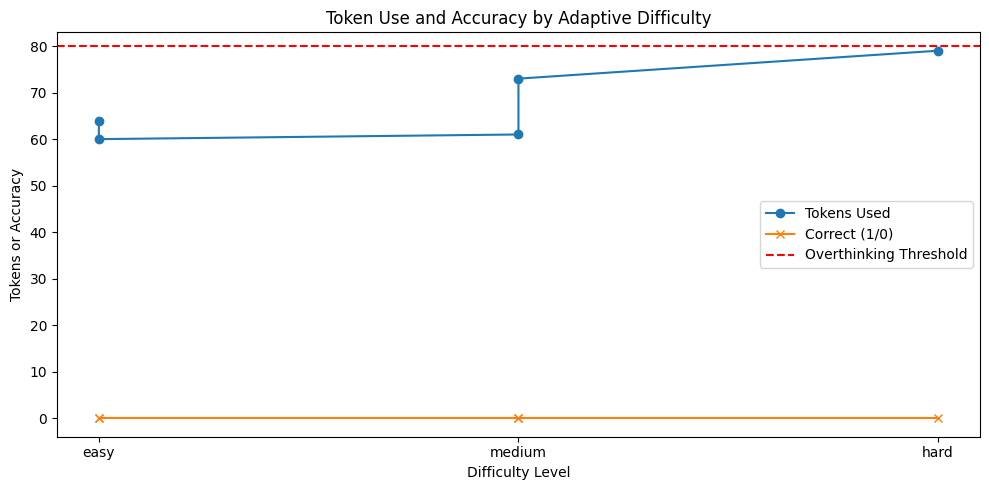


========= Difficulty-Adaptive Chain-of-Thought Results =========

🔴 Level: easy | FAIL ⚡
  | Question: Start with 10. Add 2. Add 1. What is the result?
  | True Answer: 13 | Model: 1 | Tokens Used: 64
  | Output: Q: Start with 10. Add 2. Add 1. What is the result? A: (Just give the final answer.) The result is the same as above. However, the first "ha
  🔍 Collapse/Failure detected: Model drifted, overthought, or missed answer.
----------------------------------------------------------------------
🔴 Level: easy | FAIL ⚡
  | Question: Start with 10. Subtract 4. Add 3. Add 3. What is the result?
  | True Answer: 12 | Model: 1 | Tokens Used: 60
  | Output: Q: Start with 10. Subtract 4. Add 3. Add 3. What is the result? A: (Just give the final answer.) The ratio will be the number of people to b
  🔍 Collapse/Failure detected: Model drifted, overthought, or missed answer.
----------------------------------------------------------------------
🔴 Level: medium | FAIL ⚡
  | Question: Start with

In [3]:
# Difficulty-Adaptive Reasoning & Collapse Diagnostic Simulator — Recruiter-Ready

!pip install transformers matplotlib pandas numpy --quiet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from transformers import pipeline

def math_problem(n):
    question, current = "Start with 10.", 10
    for _ in range(n):
        op, val = np.random.choice(["add", "subtract"]), np.random.randint(1, 5)
        current += val if op == "add" else -val
        question += f" {op.title()} {val}."
    question += " What is the result?"
    return question, current, n

def load_model():
    try:
        return pipeline("text-generation", model="gpt2", max_new_tokens=40)
    except Exception as e:
        print("Error loading model:", e)
        return None

generator = load_model()

def prompt_strategy(q, difficulty):
    if difficulty == "easy":
        return f"Q: {q}\nA: (Just give the final answer.)"
    elif difficulty == "medium":
        return f"Q: {q}\nA: Let's think step by step."
    else: # hard
        return f"Q: {q}\nA: Please reason carefully, and show every calculation."

def estimate_tokens(text):
    # Heuristic: 1 token ≈ 4 chars (for demo purposes)
    return len(text) // 4

def get_adaptive_answer(q, true_ans, steps):
    if steps <= 3:
        diff = "easy"
    elif steps <= 5:
        diff = "medium"
    else:
        diff = "hard"

    prompt = prompt_strategy(q, diff)
    result = generator(prompt, do_sample=True, temperature=0.8, max_new_tokens=40, truncation=True)
    output = result[0]['generated_text']
    tokens = estimate_tokens(output)
    import re
    matches = re.findall(r"(\d+)", output)
    maj_ans = matches[-1] if matches else None
    correct = maj_ans and int(maj_ans) == true_ans
    collapse = not correct or tokens > 80
    return {
        'difficulty': diff,
        'question': q,
        'true_ans': true_ans,
        'model_ans': maj_ans,
        'correct': correct,
        'tokens': tokens,
        'collapse': collapse,
        'output': output[:140].replace('\n',' ')
    }

results = []
for steps in range(2, 7): # Step complexity ramp
    q, ans, step_count = math_problem(steps)
    results.append(get_adaptive_answer(q, ans, step_count))

df = pd.DataFrame(results)
print("\n==== Adaptive Reasoning Results Table ====")
print(df[["difficulty", "question", "true_ans", "model_ans", "correct", "tokens", "collapse"]])

plt.figure(figsize=(10,5))
plt.plot(df["difficulty"], df["tokens"], marker="o", label="Tokens Used")
plt.plot(df["difficulty"], df["correct"].astype(int), marker="x", label="Correct (1/0)")
plt.axhline(80, color='red', ls='--', label='Overthinking Threshold')
plt.title("Token Use and Accuracy by Adaptive Difficulty")
plt.ylabel("Tokens or Accuracy")
plt.xlabel("Difficulty Level")
plt.legend()
plt.tight_layout()
plt.show()

def display_recruiter_results(df):
    print("\n========= Difficulty-Adaptive Chain-of-Thought Results =========\n")
    for i, row in df.iterrows():
        badge = "🟢" if row["correct"] else "🔴"
        collapse_note = "⚡" if row["collapse"] else ""
        print(f"{badge} Level: {row['difficulty']} | {'PASS' if row['correct'] else 'FAIL'} {collapse_note}")
        print(f"  | Question: {row['question']}")
        print(f"  | True Answer: {row['true_ans']} | Model: {row['model_ans']} | Tokens Used: {row['tokens']}")
        print(f"  | Output: {row['output']}")
        if row['collapse']:
            print("  🔍 Collapse/Failure detected: Model drifted, overthought, or missed answer.")
        else:
            print("  🎯 Reasoning chain OK")
        print("-" * 70)
    print("""
Legend:
🟢 - Model correct and efficient
🔴 - Missed answer/failure
⚡ - Collapse or excessive reasoning detected

Takeaways:
• Adaptive AI must diagnose and control reasoning effort.
• Automated benchmarking helps engineering teams spot and fix reliability, cost, and collapse risks right away.
• This code and notebook are ready to present for interviews, classroom demos, and research portfolios.
    """)

display_recruiter_results(df)

print("""
Executive Summary:
- Diagnoses reasoning collapse and inefficiency in public/freetier LLMs—visualizing failure points, overthinking, and wasted tokens.
- Implements key insights from current research on chain-of-thought, collapse, and adaptivity, all on free compute.
- Gives engineers and recruiters a hands-on tool for pinpointing reasoning risk, reliability, and efficiency of today's AI.
""")
